# Flow types

In the [previous notebook](https://github.com/monash-emu/summer/blob/master/docs/textbook/01-basic-model.ipynb), we introduced our general approach to creating and running a simple compartmental model of the transmission of an acute immunising infection. This basic model had only three compartments, which were linked together by two transition flows, with one additional flow through which the population simulated could exit the system (deaths). However, there are many epidemiological issues to consider when adding flows to the compartmental structure, and many different types of flow we might want to apply to our compartments.

_summer_'s [CompartmentalModel](http://summerepi.com/api/model.html) class offers a variety of intercompartmental flows that can be used to define the dynamics of a model. These consist of:

- [Transition flow](#Transition-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_transition_flow))
- [Infection density flow](#Infection-density-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_infection_density_flow))
- [Infection frequency flow](#Infection-frequency-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_infection_frequency_flow))
- [Death flow](#Death-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_death_flow))
- [Universal death flows](#Universal-death-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_universal_death_flows))
- [Crude birth flow](#Crude-birth-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_crude_birth_flow))
- [Importation flow](#Importation-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_importation_flow))
- [Replacement birth flow](#Replacement-birth-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_replacement_birth_flow))
- [Function flow](#Function-flow) ([docs](http://summerepi.com/api/model.html#summer.model.CompartmentalModel.add_function_flow))
 
Let's start off with a small amoutn of boilerplate (repeated) code that we'll need for just about all our notebooks.

In [ ]:
try:
  import google.colab
  IN_COLAB = True
  %pip install summerepi
except:
  IN_COLAB = False

In [ ]:
import pandas as pd
import numpy as np
from typing import Dict

from summer import CompartmentalModel
from summer.parameters import Parameter as param
from summer.parameters import Function as func
from summer.parameters import Time

pd.options.plotting.backend = "plotly"

In [ ]:
def get_base_model(parameters: Dict) -> CompartmentalModel:
    """
    Generate an instance of a very simple two-compartment model that allows transition
    from one of the two states to the other through a single flow linking them, 
    population distribution and parameters hard-coded.
    This is just about the simplest "closed" system possible,
    such that we're tracking where our starting population goes to and how many
    are left in their origin compartment.
    
    Returns:
        The summer model object
    """
    compartments = (
        "healthy",
        "diseased",
    )
    analysis_times = (0, 20)
    
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=[],
    )
    model.set_initial_population(
        distribution={"healthy": 1.}
    )
    model.add_transition_flow(
        "onset", 
        fractional_rate=param("onset_rate"), 
        source="healthy", 
        dest="diseased"
    )
    return model

## Transition flow

With this type of flow, people in the source compartment transition to the destination compartment at a _per capita_ rate defined by the flow's parameter.
By "_per capita_" we mean that the rate of this flow is calculated as the product of the parameter value assigned to the flow rate
and the size of the population in the source compartment.

The mean time an individual would spend in the source compartment (or "sojourn time") can then be thought of as the reciprocal of the flow rate,
**_if_** there are no other competing flows.
By competing flows, we mean flows that have the same source compartment.
Where multiple flows share a common source compartment, the sojourn time is the reciprocal of the sum of the outflows from that compartment.
If we have lots of flows coming out of one source compartment, this can quickly become too difficult to reason about fully.
However, the idea that applying a single flow can be thought of people spending a period of time equal to the reciprocal of the flow's rate
in that compartment can still be a useful way to think about what we mean by these numbers.

In the example below, we will add a progression flow called "onset" where the average time to developing disease is 0.1 time units.
This can be thought of as the mean time to disease onset for someone in the healthy category as being 10 time units.
(However, note that this does not imply that half of the population will have progressed from the healthy category after ten time units.)

In [ ]:
parameters = {
    "population": 1.,
    "onset_rate": 0.1,
}

transition_model = get_base_model(parameters)

transition_model.run(parameters=parameters)
compartment_values = transition_model.get_outputs_df()
compartment_values.plot()

## Time varying parameters (transition flow)

The rate at which people transition can be set as a constant, or it can be defined as a function of time. This is the case of **all of the flows**: every parameter can be a constant _or_ a function of time.
Parameters also take a 'computed_values' argument, which is a dictionary of values computed at runtime that is not specific to any individual flow and can be specified by the user.
We'll come back to examples of this later, but for now this is just an example of how to create a function that _summer_ can understand and can act on the `time` variable within its scope.
Older versions of summer do not include the computed values argument, and it is a good idea to provide a default of None for functions in which this argument is not used (ie depend solely on time).

In [34]:
def get_step_onset_model(parameters: Dict) -> CompartmentalModel:
    """
    
    Returns:
        The summer model object
    """
    compartments = (
        "healthy",
        "diseased",
    )
    analysis_times = (0, 20)
    
    def scaled_onset_rate(time):
        if time < 10.:
            return 0.1
        else:
            return 0.

    onset_rate = func(scaled_onset_rate, [Time])
    
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=[],
    )
    model.set_initial_population(
        distribution={"healthy": 1.}
    )
    model.add_transition_flow(
        "onset", 
        fractional_rate=onset_rate,
        source="healthy", 
        dest="diseased"
    )
    return model

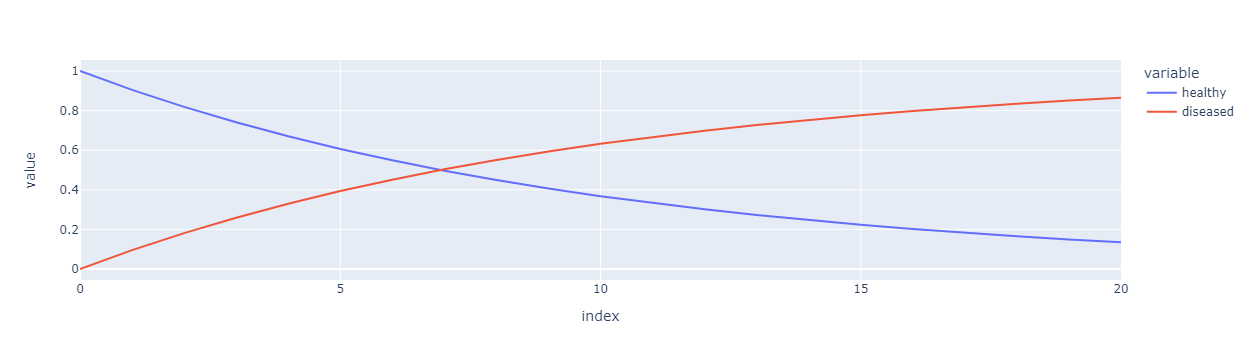

In [35]:
model = get_step_onset_model(parameters)
model.run(parameters=parameters)
compartment_values = transition_model.get_outputs_df()
compartment_values.plot()

## Infection frequency flow

Let's return to the world of infectious diseases modelling and consider an SIR model,
like the one we introduced in the first notebook (but even simpler, without the death flow).

In [ ]:
def get_sir_model(
    parameters: Dict,
) -> CompartmentalModel:
    """
    Generate an instance of an SIR model with just one fixed transition rate,
    and a frequency-dependent infection process.
    
    Args:
        parameters: The parameter values to be used in running the model
    Returns:
        The summer model object
    """
    
    # Define the 
    compartments = (
        "susceptible",
        "infectious",
        "recovered",
    )
    infectious_compartment = [
        "infectious",
    ]
    analysis_times = (
        parameters["start_time"], 
        parameters["end_time"]
    )

    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=infectious_compartment,
        takes_params=True,
    )
    
    # Check and assign infectious seed
    pop = parameters["population"]
    seed = parameters["seed"]
    suscept_pop = pop - seed
    msg = "Seed larger than population"
    assert pop >= 0., msg
    
    model.set_initial_population(
        distribution={
            "susceptible": suscept_pop, 
            "infectious": seed}
    )
    
    # Add the frequency-dependent transmission flow
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=param("contact_rate"), 
        source="susceptible", 
        dest="infectious",
    )
    
    # Add a constant recovery flow (like the transition flow introduced above)
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=param("recovery_rate"), 
        source="infectious", 
        dest="recovered",
    )
    
    return model

### Frequency-dependent transmission
This flow can be used to model infections using frequency-dependent disease transmission.

In simple models like these (without adjustments of infectious status or other stratification features), 
the frequency-dependent infection flow rate (the number of people infected per time unit) can be thought of as:

```python
# contact_rate: Rate at which effective contact occurs
# num_source: Number of people in the (susceptible) source compartment
# num_infectious: Number of in the infectious compartment(s)
# num_pop: Total number of people in the population
force_of_infection = contact_rate * num_infectious / num_pop
flow_rate = force_of_infection * num_source
```

First note that once we have calculated the force of infection,
we multiply this by the size of the source compartment
(which we will often refer to as the susceptible population).
So the force of infection can be thought of in a similar way to the parameter we apply in a transition flow.
That is, the _per capita_ rate of transition from the source to the destination compartment.

In order to calculate the force of infection, we have a parameter (`contact_rate`)
and the proportion (prevalence) of infectious persons in the population
(represented by the last two terms).

Substituting the force of infection formula into the formula for the flow rate and reordering, we can see that:
```python
flow_rate = contact_rate * num_infectious * num_source / num_pop
```
Here the last two terms of the equation together represent the proportion of the total population that is susceptible.
Given that only contacts with susceptible people will result in transmission,
the remaining proportion will be "wasted" from the perspective of the pathogen.

Therefore, this formula can be thought of as the number of infectious persons in the system,
multiplied by the proportion of their contacts that are with susceptible persons,
multiplied by some parameter.
Given this understanding, the parameter can be thought of as the per unit time rate at which
an infectious person comes into contact with other people in the population in such a way as it would result in transmission if that person was susceptible.
This quantity is often referred to as the "effective contact rate",
because it is the daily number of people that a member of this population will come into contact with other members of the population in such a way as it would result in transmission if the contact was between an infectious and a susceptible person.

In [ ]:
parameters = {
    "contact_rate": 1.,
    "recovery_rate": 0.333,
    "population": 1000.,
    "seed": 10.,
    "start_time": 0.,
    "end_time": 20.,
}

param_aware_model = get_sir_model(parameters)
param_aware_model.run(parameters=parameters)
compartment_values = param_aware_model.get_outputs_df()
compartment_values.plot()

## Infection density flow

This flow can be used to model infections using density-dependent disease transmission (as opposed to frequency dependent). This [article](https://parasiteecology.wordpress.com/2013/10/17/density-dependent-vs-frequency-dependent-disease-transmission/) may be helpful in understanding the difference between the two methods.

In unstratified models, the density-dependent infection flow rate (people infected per time unit) is calculated as:

```python
# contact_rate: Rate at which effective contact happens between two individuals, i.e. contact that would result in transmission were it to occur between a susceptible and an infectious person
# num_source: Number of people in the (susceptible) source compartment
# num_infectious: Number of people infectious
force_of_infection = contact_rate * num_infectious
flow_rate = force_of_infection * num_source
```

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 990, "I": 10})

# Add a density dependent infection flow
model.add_infection_density_flow("infection", contact_rate=1e-3, source="S", dest="I")

model.run()
plot_compartments(model)

## Death flow

With a death flow, some percent of people in a user-selected source compartment die and leave the system every time unit.

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 1000, "I": 1000})

# 3% of the infected population die per day due to the infection.
model.add_death_flow("infection_death", death_rate=0.03, source="I")

# 1% of the susceptible population die per day due to tiger attacks. 
model.add_death_flow("tiger_death", death_rate=0.01, source="S")

model.run()
plot_compartments(model)

## Universal death flow

Adding "universal deaths" is a convenient way to set up a death flow for every compartment, which can account for non-disease mortality (heart disease and getting hit by a bus). This is functionally the same as manually adding a death flow for every compartment. You can adjust the universal death rate for particlar strata later during the stratification process (e.g. age-based mortality).

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 200, "R": 100})

# 2% of the population die per day for non-infection-related reasons.
model.add_universal_death_flows("universal_death", death_rate=0.02)

model.run()
plot_compartments(model)

## Crude birth flow

Some percentage of the total population are born into the destination compartment every time unit.

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 600, "R": 500})

# 5% of the total population per day are born as susceptible.
model.add_crude_birth_flow("birth", birth_rate=0.05, dest="S")

model.run()
plot_compartments(model)

## Importation flow

An absolute number of people arrive in the destination per time unit. This can be used to model arrivals from outside of the modelled region.

Note that 'split_imports' determines whether this number is split over the existing destination compartments (True), or the full number of people sent to each (False).  In this example the behaviour is the same (since the flows are to a single compartment), but for stratified models, this can be an important distinction - we will cover this in more detail in the Stratification notebook.

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 700, "I": 600, "R": 500})

# 12 susceptible people arrive per year.
model.add_importation_flow("imports", num_imported=12, dest="S", split_imports=True)

# 6 infected people arrive per year.
model.add_importation_flow("imports", num_imported=6, dest="I", split_imports=True)

model.run()
plot_compartments(model)

## Replacement birth flow

Add a flow to replace the number of deaths into the destination compartment. This means the total population should be conserved over time.

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 650, "I": 600, "R": 0})

# 5% of the infected population die per year due to infection.
model.add_death_flow("infection_death", death_rate=0.05, source="I")

# The infected people who have died arrive back in the susceptible compartment.
model.add_replacement_birth_flow("births", dest="S")

model.run()
plot_compartments(model)

## Function flow

A function flow gives you more control over how a flow should work. This is when you need to include more complex behaviour in your model which cannot be expressed using the built-in flows above.

In [ ]:
model = build_model()
model.set_initial_population(distribution={"S": 650, "I": 100, "R": 0})

def get_vaccination_flow_rate(flow, comp_names, comp_vals, flows, flow_rates, derived_values, time):
    """
    Returns the flow-rate of susceptible people who get vaccinated and become recovered.
    
    Args:
        flow: The flow object being run
        comp_names: List of compartment names (Compartment)
        comp_vals: Array of compartment values at this timestep
        flows: List of flow objects (used to calculate flow rates)
        flow_rates: Calculated flow rate for each non-function flow at this timestep
        time: Current timestep
    
    Returns: The flow rate (float)
    """
    if time < 5:
        # Vaccinate 10 people per day until day 5
        return 10
    elif 5 < time < 15:
        # Vaccinate 5% of the total population per day until day 15
        return 0.05 * comp_vals.sum()
    else:
        # After day 15 stop vaccinations, because we ran out of money
        return 0
    

# Use a custom function to model vaccinations
model.add_function_flow("vacinnation", flow_rate_func=get_vaccination_flow_rate, source="S", dest="R")

# Use Runge-Kutta 4 solver to better capture sharp discontinuity.
model.run(solver="rk4")
plot_compartments(model, times=[0, 20])

## Summary

That's it for now, now you know how to use all the flow types available in summer to define the dynamics of your compartmental model. In future examples you will see how to use these flows in a stratified model.

A detailed API reference of the CompartmentalModel class can be found [here](http://summerepi.com/api/model.html)